# D&D Creativity & Semantic Analysis Tutorial

This notebook demonstrates advanced semantic analysis of D&D gameplay logs using embeddings, topic modeling, and creativity metrics. We'll explore narrative evolution, thematic transitions, and semantic novelty patterns.

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Semantic Embeddings](#embeddings)
3. [Semantic Distance Analysis](#distance)
4. [Session Novelty Metrics](#novelty)
5. [Topic Modeling](#topics)
6. [Topic Transition Analysis](#transitions)
7. [Topic Change Rate](#change-rate)
8. [Advanced Visualizations](#visualizations)

## Setup and Data Loading {#setup}

In [1]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our analysis modules
import dnd_analysis as dnd
import creative_metrics as cm

# Set up plotting style for creativity analysis
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print("Note: Make sure you have installed the required packages:")
print("pip install sentence-transformers bertopic hdbscan umap-learn gensim")

Libraries imported successfully!
Note: Make sure you have installed the required packages:
pip install sentence-transformers bertopic hdbscan umap-learn gensim


In [2]:
# Load D&D data (reusing the data loading from previous tutorial)
json_file_path = 'Game-Data/phandelver-labels.json'

try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    print(f"Successfully loaded JSON data from {json_file_path}")
except FileNotFoundError:
    print(f"File not found: {json_file_path}")
    print("Using sample data for demonstration...")
    # Create expanded sample data for creativity analysis
    json_data = {
        "sample-campaign": {
            "1": {
                "date": "2019-03-18T06:19:37",
                "player": "DM",
                "character": "Dungeon Master",
                "text": "You enter a dark, foreboding dungeon. The air is thick with mystery and danger.",
                "actions": {},
                "name_mentions": [],
                "in_combat": False
            },
            "2": {
                "date": "2019-03-18T07:20:15",
                "player": "Player1",
                "character": "Aragorn",
                "text": "I carefully examine the stone walls for any hidden switches or traps.",
                "actions": {"check": {"roll": ["15"]}},
                "name_mentions": ["Aragorn"],
                "in_combat": False
            },
            "3": {
                "date": "2019-03-18T08:15:22",
                "player": "Player2",
                "character": "Legolas",
                "text": "\"We should be cautious,\" I whisper to my companions. \"These ruins hold ancient secrets.\"",
                "actions": {},
                "name_mentions": ["Legolas"],
                "in_combat": False
            },
            "4": {
                "date": "2019-03-18T09:30:45",
                "player": "DM",
                "character": "Dungeon Master",
                "text": "As you explore deeper, you discover a magnificent crystal chamber filled with glowing gems and strange magical energies.",
                "actions": {},
                "name_mentions": [],
                "in_combat": False
            },
            "5": {
                "date": "2019-03-18T10:45:12",
                "player": "Player1",
                "character": "Aragorn",
                "text": "The magical aura here is overwhelming. I cast Detect Magic to understand what we're dealing with.",
                "actions": {"spell": {"name": "Detect Magic"}},
                "name_mentions": ["Aragorn"],
                "in_combat": False
            }
        }
    }

# Convert to DataFrame
df = dnd.load_dnd_data(json_data)

print(f"\nDataFrame created with {len(df)} messages")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique players: {df['player'].nunique()}")
print(f"Sample of text lengths: {df['word_count'].describe()}")

# Display sample messages
print("\nSample messages for creativity analysis:")
for i, row in df.head(3).iterrows():
    print(f"[{row['player']}]: {row['text'][:100]}...")

Successfully loaded JSON data from Game-Data/phandelver-labels.json

DataFrame created with 4289 messages
Date range: 2019-03-18 06:19:37 to 2020-07-30 17:15:19
Unique players: 7
Sample of text lengths: count    4289.000000
mean       59.878060
std        79.699273
min         0.000000
25%        17.000000
50%        34.000000
75%        68.000000
max       916.000000
Name: word_count, dtype: float64

Sample messages for creativity analysis:
[RobJFalcon]: You are in the city of Neverwinter , where a dwarf named Gundren Rockseeker asked you to bring a wag...
[GeneralSanspants]: I am Az Emberi. ( 6 foot lean. Young looks about 25. Long nose. Sharp pronounced canine teeth. Green...
[Gallowscall]: "Mornin fellers." The Dwarf cocks his head to the side before he spits in an awkward attempt to be p...


## Semantic Embeddings {#embeddings}

Generate high-dimensional embeddings that capture semantic meaning of each message using Sentence-BERT.

In [3]:
# Generate semantic embeddings
print("Generating semantic embeddings...")
print("This may take a few moments for large datasets.")

try:
    embeddings = cm.get_embeddings(df, model_name="all-MiniLM-L6-v2")
    print(f"✅ Generated embeddings with shape: {embeddings.shape}")
    print(f"Embedding dimensionality: {embeddings.shape[1]}")
    print(f"Memory usage: {embeddings.nbytes / (1024**2):.2f} MB")
    
    # Basic embedding statistics
    print("\nEmbedding statistics:")
    print(f"Mean magnitude: {np.linalg.norm(embeddings, axis=1).mean():.3f}")
    print(f"Min/Max values: {embeddings.min():.3f} / {embeddings.max():.3f}")
    
except ImportError as e:
    print(f"⚠️  Error: {e}")
    print("Please install sentence-transformers: pip install sentence-transformers")
    embeddings = None
except Exception as e:
    print(f"⚠️  Unexpected error: {e}")
    embeddings = None

Generating semantic embeddings...
This may take a few moments for large datasets.
Loading embeddings from cache: embeddings_cache/embeddings_4c692fe3a5a983945267e715514940d4.pkl
✅ Generated embeddings with shape: (4289, 384)
Embedding dimensionality: 384
Memory usage: 6.28 MB

Embedding statistics:
Mean magnitude: 1.000
Min/Max values: -0.245 / 0.265


## Semantic Distance Analysis {#distance}

Measure how semantically different each message is from previous messages to identify narrative shifts and creative moments.

Calculating semantic distances...
✅ Calculated semantic distances
Window 1 - Mean distance: 0.623, Std: 0.142
Window 3 - Mean distance: 0.607, Std: 0.141
Final cumulative distance (w1): 2672.574


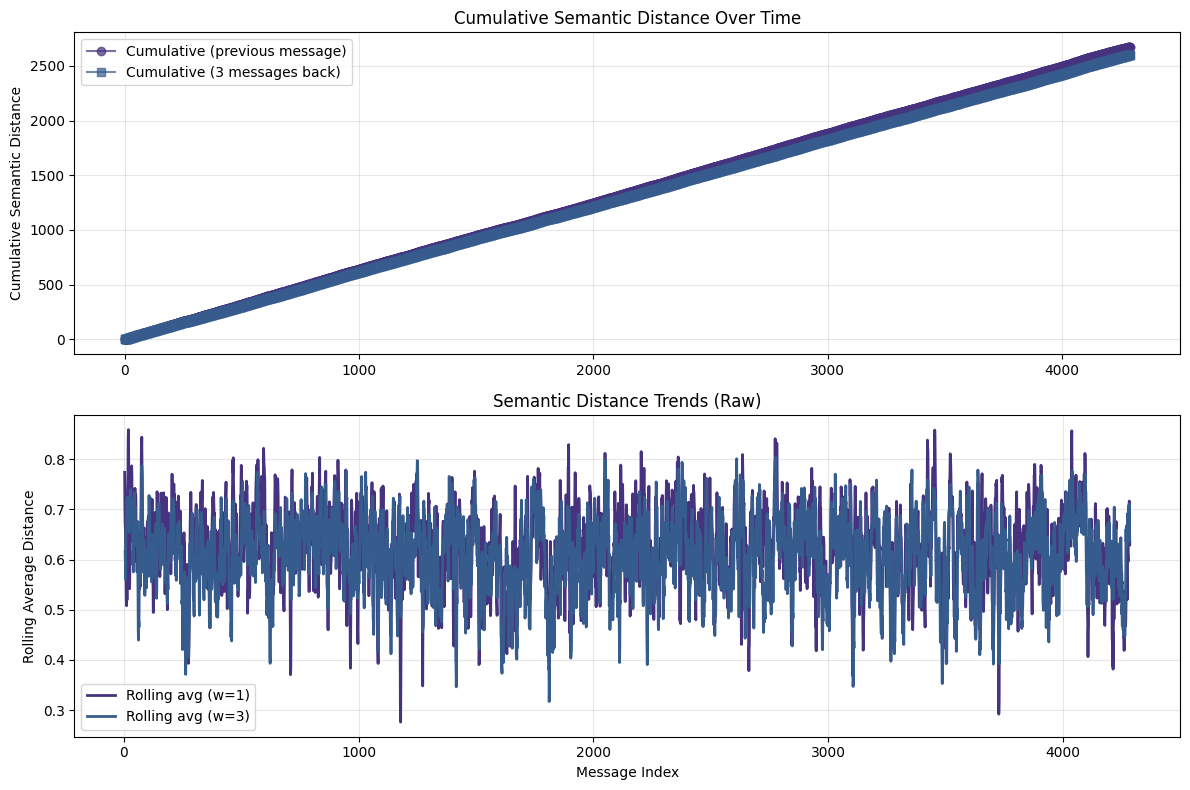


🎨 High-Novelty Messages (distance > 0.751):
[GeneralSanspants] (0.794): I am Az Emberi. ( 6 foot lean. Young looks about 25. Long nose. Sharp pronounced canine teeth. Green gold eyes with a large pupil to iris ratio. Ears ...
[Gallowscall] (0.753): "Mornin fellers." The Dwarf cocks his head to the side before he spits in an awkward attempt to be polite. "Fjolnir." He smiled as he wiped the bare c...
[GeneralSanspants] (0.821): I will drive the cart if no one else wishes to do so....
[Gallowscall] (0.826): Fjolnir scratches his overgrown high-and-tight hair. "To be honest I've met him before but I can't recall where. I used to run goods like this on skif...
[Nockturen] (0.802): I would like to roll an investigation on each or all of my travel mates...
[Evildrive] (0.790): I just look around, see what's around....
[Nockturen] (0.853): Beau 10
Mike 20
Thomas 18
Lee 20...
[RobJFalcon] (0.893): Coincidence. Hymir notices that:
Fjolnir is a dwarf, little over 5' tall.
Az Emberi is about 6' 

In [4]:
if embeddings is not None:
    # Calculate semantic distances with different window sizes
    print("Calculating semantic distances...")
    
    # Distance to previous message
    distances_1 = cm.semantic_distance(df, embeddings, window=1, metric="cosine")
    df['semantic_distance_w1'] = distances_1
    
    # Distance to message 3 steps back
    distances_3 = cm.semantic_distance(df, embeddings, window=3, metric="cosine")
    df['semantic_distance_w3'] = distances_3
    
    # Calculate cumulative semantic distances
    df['cumulative_distance_w1'] = distances_1.fillna(0).cumsum()
    df['cumulative_distance_w3'] = distances_3.fillna(0).cumsum()
    
    print(f"✅ Calculated semantic distances")
    print(f"Window 1 - Mean distance: {distances_1.mean():.3f}, Std: {distances_1.std():.3f}")
    print(f"Window 3 - Mean distance: {distances_3.mean():.3f}, Std: {distances_3.std():.3f}")
    print(f"Final cumulative distance (w1): {df['cumulative_distance_w1'].iloc[-1]:.3f}")
    
    # Set up plots directory
    from pathlib import Path
    plots_dir = Path('Plots')
    plots_dir.mkdir(exist_ok=True)
    
    def save_plot(filename):
        filepath = plots_dir / filename
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    
    # Plot semantic distance timeline
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Cumulative distances
    ax1.plot(df.index, df['cumulative_distance_w1'], 'o-', alpha=0.7, label='Cumulative (previous message)')
    ax1.plot(df.index, df['cumulative_distance_w3'], 's-', alpha=0.7, label='Cumulative (3 messages back)')
    ax1.set_ylabel('Cumulative Semantic Distance')
    ax1.set_title('Cumulative Semantic Distance Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rolling averages for trend analysis
    if len(df) > 5:
        rolling_w1 = df['semantic_distance_w1'].rolling(window=min(5, len(df)), center=True).mean()
        rolling_w3 = df['semantic_distance_w3'].rolling(window=min(5, len(df)), center=True).mean()
        
        ax2.plot(df.index, rolling_w1, linewidth=2, label='Rolling avg (w=1)')
        ax2.plot(df.index, rolling_w3, linewidth=2, label='Rolling avg (w=3)')
        ax2.set_xlabel('Message Index')
        ax2.set_ylabel('Rolling Average Distance')
        ax2.set_title('Semantic Distance Trends (Raw)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot('semantic_distances.png')
    plt.show()
    
    # Identify high-novelty messages
    if len(df) > 1:
        novelty_threshold = distances_1.quantile(0.8)  # Top 20% most novel
        novel_messages = df[df['semantic_distance_w1'] > novelty_threshold]
        
        print(f"\n🎨 High-Novelty Messages (distance > {novelty_threshold:.3f}):")
        for i, row in novel_messages.iterrows():
            print(f"[{row['player']}] ({row['semantic_distance_w1']:.3f}): {row['text'][:150]}...")

else:
    print("⚠️  Skipping semantic distance analysis (embeddings not available)")

## Session Novelty Metrics {#novelty}

Analyze creativity patterns at the session level by measuring pairwise semantic distances within gaming sessions.

Analyzing session-level novelty...
✅ Analyzed 1 sessions

Session Novelty Summary:
       mean_distance  max_distance  post_count
count       1.000000      1.000000         1.0
mean        0.809756      1.225935      4289.0
std              NaN           NaN         NaN
min         0.809756      1.225935      4289.0
25%         0.809756      1.225935      4289.0
50%         0.809756      1.225935      4289.0
75%         0.809756      1.225935      4289.0
max         0.809756      1.225935      4289.0


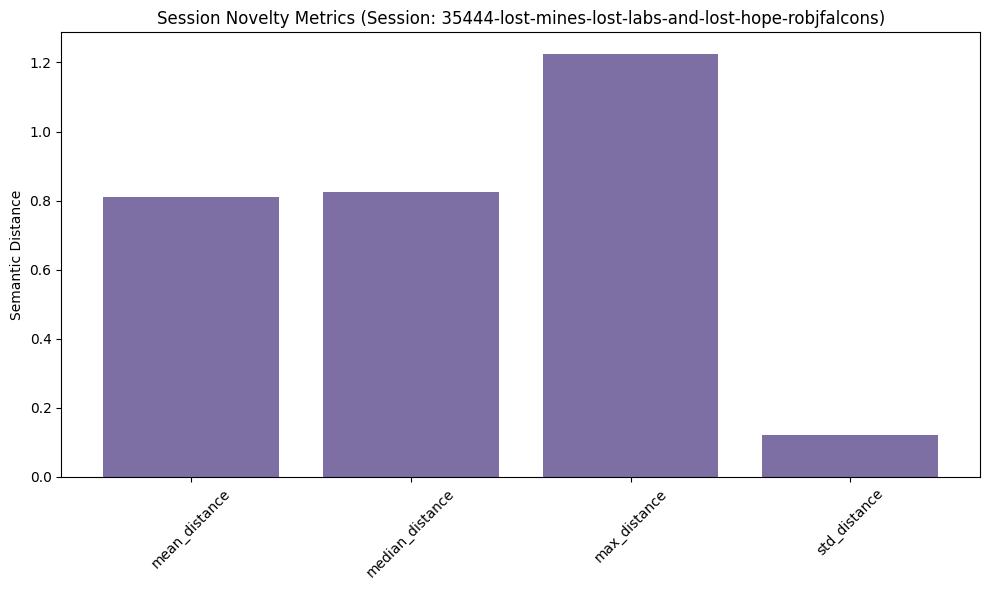


📊 Session 35444-lost-mines-lost-labs-and-lost-hope-robjfalcons Analysis:
  📝 Posts: 4289
  🎯 Mean novelty: 0.810
  🚀 Peak novelty: 1.226
  📈 Consistency: 0.120


In [5]:
if embeddings is not None:
    # Create session novelty analysis
    print("Analyzing session-level novelty...")
    
    try:
        session_stats = cm.session_novelty(df, embeddings, session_col="campaign_id")
        
        if len(session_stats) > 0:
            print(f"✅ Analyzed {len(session_stats)} sessions")
            print("\nSession Novelty Summary:")
            print(session_stats[['mean_distance', 'max_distance', 'post_count']].describe())
            
            # Plot session novelty statistics
            if len(session_stats) > 1:
                cm.plot_session_novelty(session_stats)
                plt.savefig('session_novelty.png', dpi=300, bbox_inches='tight')
            else:
                # Single session - show different visualization
                plt.figure(figsize=(10, 6))
                session = session_stats.iloc[0]
                metrics = ['mean_distance', 'median_distance', 'max_distance', 'std_distance']
                values = [session[metric] for metric in metrics]
                
                plt.bar(metrics, values, alpha=0.7)
                plt.title(f'Session Novelty Metrics (Session: {session["session_id"]})')
                plt.ylabel('Semantic Distance')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig('session_novelty.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                print(f"\n📊 Session {session['session_id']} Analysis:")
                print(f"  📝 Posts: {session['post_count']}")
                print(f"  🎯 Mean novelty: {session['mean_distance']:.3f}")
                print(f"  🚀 Peak novelty: {session['max_distance']:.3f}")
                print(f"  📈 Consistency: {session['std_distance']:.3f}")
        else:
            print("⚠️  No sessions found with enough data for analysis")
            
    except Exception as e:
        print(f"⚠️  Error in session analysis: {e}")
        session_stats = pd.DataFrame()

else:
    print("⚠️  Skipping session novelty analysis (embeddings not available)")
    session_stats = pd.DataFrame()

## Topic Modeling {#topics}

Discover thematic topics in the gameplay using advanced topic modeling (BERTopic or LDA).

2025-06-24 17:26:15,311 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Running topic modeling analysis...
Extracting 10 topics...


2025-06-24 17:26:20,710 - BERTopic - Dimensionality - Completed ✓
2025-06-24 17:26:20,711 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-24 17:26:20,776 - BERTopic - Cluster - Completed ✓
2025-06-24 17:26:20,776 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-24 17:26:20,899 - BERTopic - Representation - Completed ✓
2025-06-24 17:26:20,900 - BERTopic - Topic reduction - Reducing number of topics
2025-06-24 17:26:20,908 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-24 17:26:21,011 - BERTopic - Representation - Completed ✓
2025-06-24 17:26:21,012 - BERTopic - Topic reduction - Reduced number of topics from 68 to 10


✅ Topic modeling completed
Topics found: 10 unique topics
Topic distribution:
topic
 0    1667
-1    1458
 1     618
 2     162
 3     150
 4      94
 5      73
 6      35
 7      17
 8      15
Name: count, dtype: int64

🎭 Topic Analysis:

Topic 0 (1667 messages):
  1. I am Az Emberi. ( 6 foot lean. Young looks about 25. Long nose. Sharp pronounced canine teeth. Green...
  2. Fjolnir scratches his overgrown high-and-tight hair. "To be honest I've met him before but I can't r...
  Top contributors: RobJFalcon(408), CashlessRegent(305), Gallowscall(276)

Topic 1 (618 messages):
  1. You are in the city of Neverwinter , where a dwarf named Gundren Rockseeker asked you to bring a wag...
  2. I met Gundren in a bar. He was drunk dnd fell off his stool. I helped him up. He offered me a job. I...
  Top contributors: RobJFalcon(164), Evildrive(153), GeneralSanspants(132)

Topic 2 (162 messages):
  1. I would like to roll an investigation on each or all of my travel mates...
  2. Can I investig

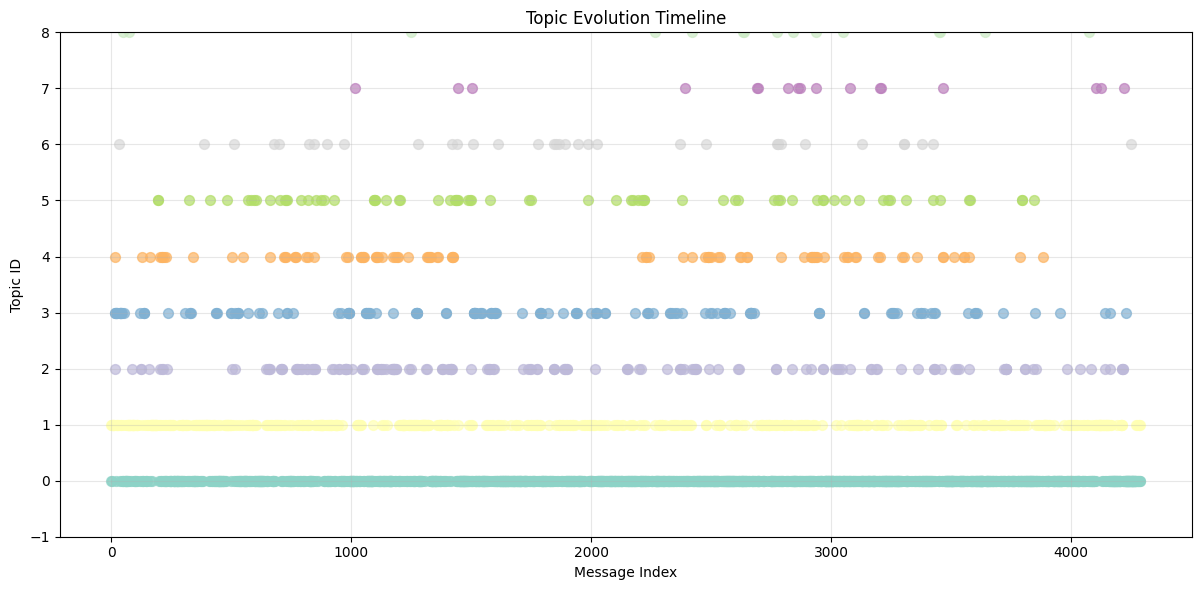

In [12]:
# Topic modeling analysis
print("Running topic modeling analysis...")

try:
    # Try BERTopic first, fall back to LDA if needed
    n_topics = min(10, max(3, len(df) // 2))  # Adaptive number of topics

    print(f"Extracting {n_topics} topics...")
    topics, topic_model = cm.topic_model(
        df,
        n_topics=n_topics,
        engine="bertopic",
        embeddings=embeddings if embeddings is not None else None)

    # Add topics to DataFrame
    df['topic'] = topics

    print(f"✅ Topic modeling completed")
    print(f"Topics found: {topics.nunique()} unique topics")
    print(f"Topic distribution:")
    print(topics.value_counts().head(10))

    # Analyze topic characteristics
    print("\n🎭 Topic Analysis:")
    for topic_id in sorted(topics.unique()):
        if topic_id == -1:
            continue  # Skip outlier topic

        topic_messages = df[df['topic'] == topic_id]
        print(f"\nTopic {topic_id} ({len(topic_messages)} messages):")

        # Show sample messages
        sample_msgs = topic_messages['text'].head(2).tolist()
        for i, msg in enumerate(sample_msgs, 1):
            print(f"  {i}. {msg[:100]}...")

        # Show top players in this topic
        top_players = topic_messages['player'].value_counts().head(3)
        if len(top_players) > 0:
            print(
                f"  Top contributors: {', '.join([f'{player}({count})' for player, count in top_players.items()])}"
            )

    # Plot topic timeline
    if len(df) > 1:
        plt.figure(figsize=(12, 6))

        # Create timeline of topics
        topic_colors = plt.cm.Set3(np.linspace(0, 1, topics.nunique()))

        for i, (idx, row) in enumerate(df.iterrows()):
            topic_id = row['topic']
            if topic_id >= 0:  # Skip outlier topics
                color_idx = topic_id % len(topic_colors)
                plt.scatter(i,
                            topic_id,
                            c=[topic_colors[color_idx]],
                            s=50,
                            alpha=0.7)

        plt.xlabel('Message Index')
        plt.ylabel('Topic ID')
        plt.title('Topic Evolution Timeline')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('topic_timeline.png', dpi=300, bbox_inches='tight')
        plt.ylim([-1, 8])
        plt.show()

except Exception as e:
    print(f"⚠️  Topic modeling failed: {e}")
    print("This might be due to missing dependencies or insufficient data.")
    df['topic'] = 0  # Assign default topic
    topic_model = None

## Topic Transition Analysis {#transitions}

Analyze how the narrative flows between different thematic topics using Markov chain analysis.

Analyzing topic transitions...
✅ Transition matrix computed (10 topics)

Topic Transition Probabilities:
       -1      0      1      2      3      4      5      6      7      8
-1  0.355  0.391  0.150  0.030  0.026  0.021  0.014  0.008  0.005  0.001
 0  0.336  0.462  0.109  0.022  0.023  0.017  0.016  0.008  0.002  0.005
 1  0.338  0.278  0.278  0.034  0.019  0.015  0.018  0.008  0.005  0.006
 2  0.265  0.235  0.080  0.284  0.006  0.074  0.037  0.019  0.000  0.000
 3  0.253  0.300  0.040  0.033  0.360  0.013  0.000  0.000  0.000  0.000
 4  0.436  0.255  0.085  0.043  0.032  0.074  0.053  0.011  0.011  0.000
 5  0.425  0.315  0.137  0.027  0.014  0.027  0.041  0.000  0.014  0.000
 6  0.286  0.371  0.114  0.057  0.057  0.057  0.029  0.029  0.000  0.000
 7  0.294  0.412  0.176  0.000  0.000  0.118  0.000  0.000  0.000  0.000
 8  0.267  0.400  0.067  0.133  0.000  0.000  0.067  0.000  0.067  0.000


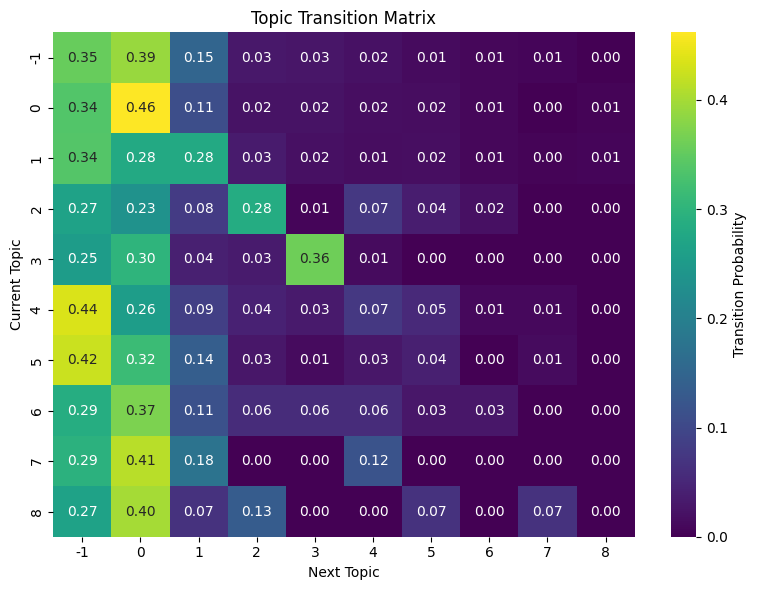


🔄 Transition Analysis:
Top topic transitions:
  Topic 4 → Topic -1: 0.436
  Topic 5 → Topic -1: 0.425
  Topic 7 → Topic 0: 0.412
  Topic 8 → Topic 0: 0.400
  Topic -1 → Topic 0: 0.391

Average topic persistence: 0.188


In [7]:
# Topic transition analysis
if 'topic' in df.columns and len(df) > 1:
    print("Analyzing topic transitions...")
    
    try:
        # Calculate transition matrix
        transition_matrix = cm.topic_transition_matrix(df, topic_col="topic")
        
        print(f"✅ Transition matrix computed ({transition_matrix.shape[0]} topics)")
        print("\nTopic Transition Probabilities:")
        print(transition_matrix.round(3))
        
        # Visualize transition matrix
        if transition_matrix.shape[0] > 1:
            plt.figure(figsize=(8, 6))
            sns.heatmap(transition_matrix, annot=True, fmt='.2f', 
                       cmap='viridis', cbar_kws={'label': 'Transition Probability'})
            plt.title('Topic Transition Matrix')
            plt.xlabel('Next Topic')
            plt.ylabel('Current Topic')
            plt.tight_layout()
            plt.savefig('topic_transitions.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Analyze interesting transitions
            print("\n🔄 Transition Analysis:")
            
            # Find most common transitions
            transitions = []
            for i in transition_matrix.index:
                for j in transition_matrix.columns:
                    if i != j and transition_matrix.loc[i, j] > 0:
                        transitions.append((i, j, transition_matrix.loc[i, j]))
            
            if transitions:
                transitions.sort(key=lambda x: x[2], reverse=True)
                print("Top topic transitions:")
                for from_topic, to_topic, prob in transitions[:5]:
                    print(f"  Topic {from_topic} → Topic {to_topic}: {prob:.3f}")
            
            # Self-transitions (topic persistence)
            self_transitions = [transition_matrix.loc[i, i] for i in transition_matrix.index]
            avg_persistence = np.mean(self_transitions)
            print(f"\nAverage topic persistence: {avg_persistence:.3f}")
            
        else:
            print("Only one topic found - no transitions to analyze")
    
    except Exception as e:
        print(f"⚠️  Error in transition analysis: {e}")

else:
    print("⚠️  Skipping transition analysis (no topic data available)")

## Topic Change Rate {#change-rate}

Measure the rate of topic changes over time to identify periods of high narrative dynamism.

Analyzing topic change rates...
✅ Topic change rate calculated (window size: 10)
Mean change rate: 0.634
Max change rate: 1.000


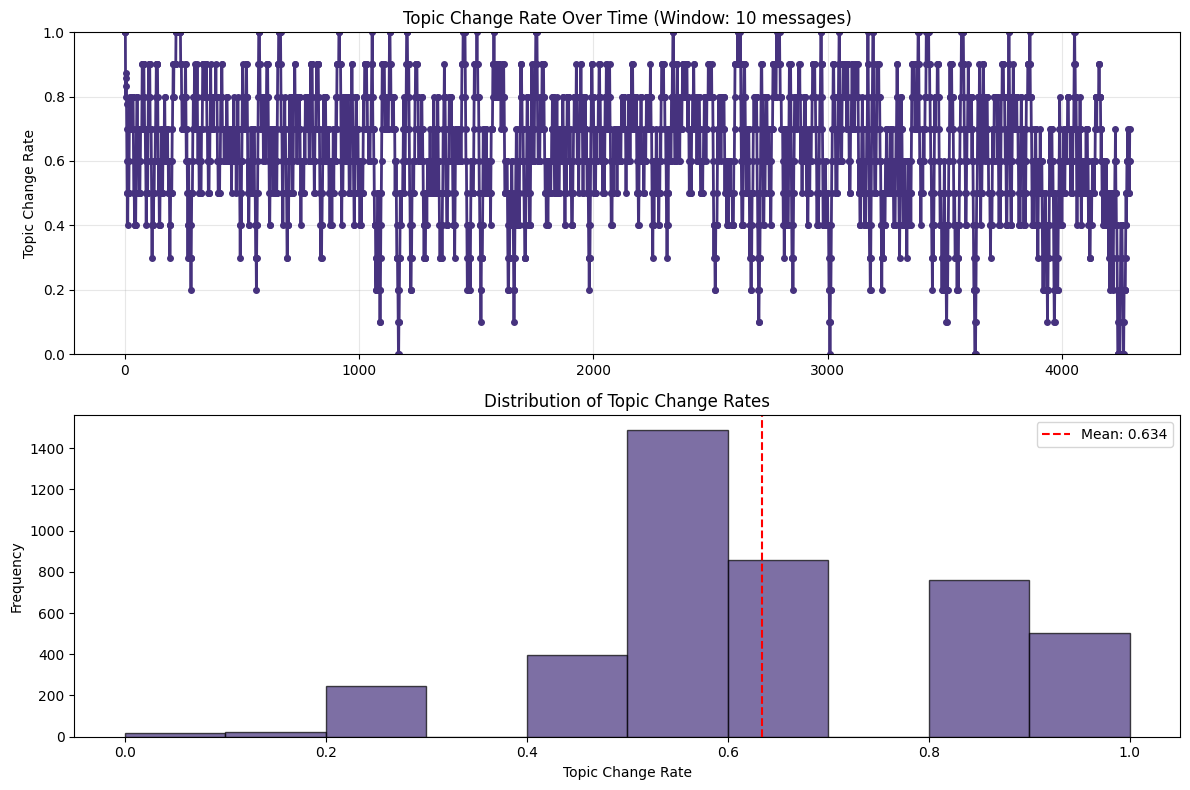


🌪️  High-Dynamism Periods (change rate > 0.800):
Message 0 (1.000): You are in the city of Neverwinter , where a dwarf named Gundren Rockseeker asked you to bring a wag...
Message 1 (1.000): I am Az Emberi. ( 6 foot lean. Young looks about 25. Long nose. Sharp pronounced canine teeth. Green...
Message 2 (1.000): "Mornin fellers." The Dwarf cocks his head to the side before he spits in an awkward attempt to be p...

📊 Correlation with semantic distance: 0.159


In [8]:
# Topic change rate analysis
if 'topic' in df.columns and len(df) > 2:
    print("Analyzing topic change rates...")
    
    try:
        # Calculate change rate with different window sizes
        window_size = min(10, max(3, len(df) // 2))
        change_rate = cm.topic_change_rate(df, topic_col="topic", window=window_size)
        
        df['topic_change_rate'] = change_rate
        
        print(f"✅ Topic change rate calculated (window size: {window_size})")
        print(f"Mean change rate: {change_rate.mean():.3f}")
        print(f"Max change rate: {change_rate.max():.3f}")
        
        # Plot change rate over time
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Topic change rate timeline
        ax1.plot(df.index, change_rate, 'o-', linewidth=2, markersize=4)
        ax1.set_ylabel('Topic Change Rate')
        ax1.set_title(f'Topic Change Rate Over Time (Window: {window_size} messages)')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)
        
        # Histogram of change rates
        ax2.hist(change_rate.dropna(), bins=min(10, len(change_rate.dropna())), 
                alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Topic Change Rate')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Topic Change Rates')
        ax2.axvline(change_rate.mean(), color='red', linestyle='--', 
                   label=f'Mean: {change_rate.mean():.3f}')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('topic_change_rate.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Identify periods of high dynamism
        high_change_threshold = change_rate.quantile(0.8)
        dynamic_periods = df[df['topic_change_rate'] > high_change_threshold]
        
        if len(dynamic_periods) > 0:
            print(f"\n🌪️  High-Dynamism Periods (change rate > {high_change_threshold:.3f}):")
            for i, row in dynamic_periods.head(3).iterrows():
                print(f"Message {i} ({row['topic_change_rate']:.3f}): {row['text'][:100]}...")
        
        # Correlate change rate with other metrics
        if 'semantic_distance_w1' in df.columns:
            correlation = df['topic_change_rate'].corr(df['semantic_distance_w1'])
            print(f"\n📊 Correlation with semantic distance: {correlation:.3f}")
            
            if not pd.isna(correlation) and abs(correlation) > 0.3:
                relationship = "positive" if correlation > 0 else "negative"
                print(f"   → {relationship.title()} relationship detected!")
    
    except Exception as e:
        print(f"⚠️  Error in change rate analysis: {e}")

else:
    print("⚠️  Skipping change rate analysis (insufficient topic data)")

## Advanced Visualizations {#visualizations}

Create comprehensive visualizations that combine multiple creativity metrics for deeper insights.

Creating creativity analysis dashboard...


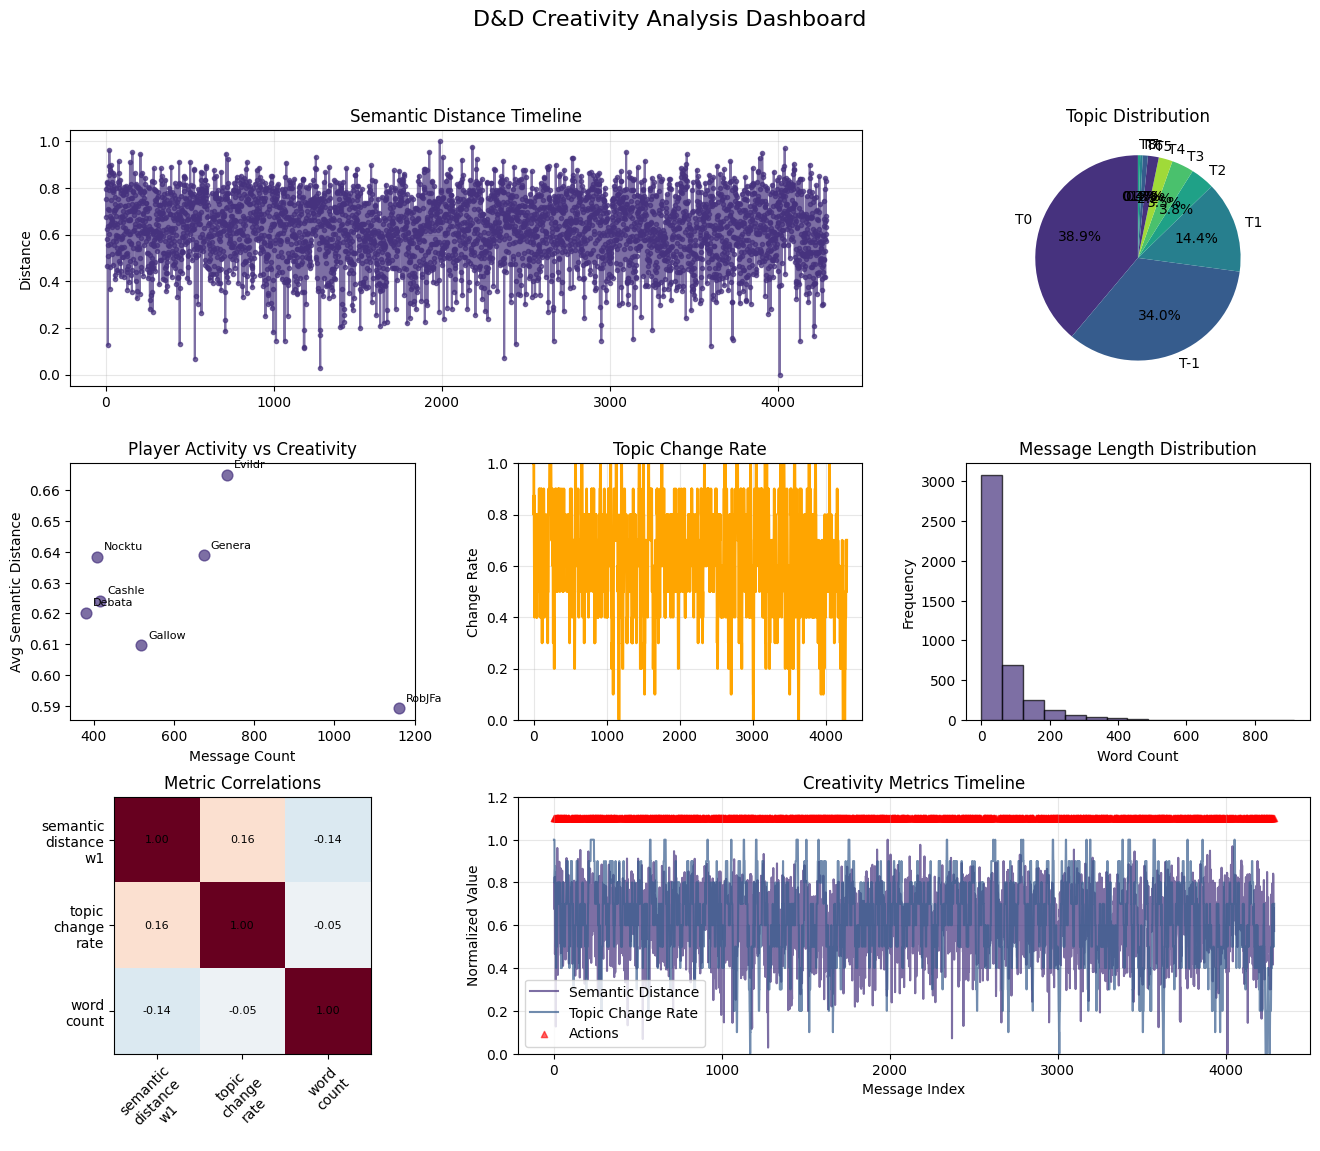

✅ Creativity dashboard created successfully!


In [9]:
# Create comprehensive creativity dashboard
print("Creating creativity analysis dashboard...")

# Set up the dashboard layout
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

try:
    # 1. Semantic Distance Timeline (top row, spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    if 'semantic_distance_w1' in df.columns:
        ax1.plot(df.index, df['semantic_distance_w1'], 'o-', alpha=0.7, markersize=3)
        ax1.set_title('Semantic Distance Timeline')
        ax1.set_ylabel('Distance')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'Semantic Distance\nNot Available', 
                ha='center', va='center', transform=ax1.transAxes)
    
    # 2. Topic Distribution (top right)
    ax2 = fig.add_subplot(gs[0, 2])
    if 'topic' in df.columns:
        topic_counts = df['topic'].value_counts()
        if len(topic_counts) > 1:
            ax2.pie(topic_counts.values, labels=[f'T{i}' for i in topic_counts.index], 
                   autopct='%1.1f%%', startangle=90)
            ax2.set_title('Topic Distribution')
        else:
            ax2.bar([0], [len(df)], alpha=0.7)
            ax2.set_title('Single Topic')
            ax2.set_xticks([0])
            ax2.set_xticklabels(['All Messages'])
    else:
        ax2.text(0.5, 0.5, 'Topic Data\nNot Available', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # 3. Player Activity vs Creativity (middle left)
    ax3 = fig.add_subplot(gs[1, 0])
    if 'semantic_distance_w1' in df.columns:
        player_creativity = df.groupby('player')['semantic_distance_w1'].agg(['mean', 'count'])
        if len(player_creativity) > 1:
            scatter = ax3.scatter(player_creativity['count'], player_creativity['mean'], 
                                alpha=0.7, s=60)
            ax3.set_xlabel('Message Count')
            ax3.set_ylabel('Avg Semantic Distance')
            ax3.set_title('Player Activity vs Creativity')
            
            # Add player labels
            for player, row in player_creativity.iterrows():
                ax3.annotate(player[:6], (row['count'], row['mean']), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        else:
            ax3.bar(range(len(player_creativity)), player_creativity['mean'], alpha=0.7)
            ax3.set_title('Player Creativity')
            ax3.set_xticks(range(len(player_creativity)))
            ax3.set_xticklabels(player_creativity.index, rotation=45)
    else:
        ax3.text(0.5, 0.5, 'Player Creativity\nNot Available', 
                ha='center', va='center', transform=ax3.transAxes)
    
    # 4. Topic Change Rate (middle center)
    ax4 = fig.add_subplot(gs[1, 1])
    if 'topic_change_rate' in df.columns:
        ax4.plot(df.index, df['topic_change_rate'], linewidth=2, color='orange')
        ax4.set_title('Topic Change Rate')
        ax4.set_ylabel('Change Rate')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 1)
    else:
        ax4.text(0.5, 0.5, 'Topic Change Rate\nNot Available', 
                ha='center', va='center', transform=ax4.transAxes)
    
    # 5. Message Length Distribution (middle right)
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.hist(df['word_count'], bins=min(15, len(df)), alpha=0.7, edgecolor='black')
    ax5.set_title('Message Length Distribution')
    ax5.set_xlabel('Word Count')
    ax5.set_ylabel('Frequency')
    
    # 6. Creativity Correlation Matrix (bottom left)
    ax6 = fig.add_subplot(gs[2, 0])
    creativity_cols = [col for col in ['semantic_distance_w1', 'topic_change_rate', 'word_count'] 
                      if col in df.columns]
    if len(creativity_cols) > 1:
        corr_matrix = df[creativity_cols].corr()
        im = ax6.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
        ax6.set_xticks(range(len(creativity_cols)))
        ax6.set_yticks(range(len(creativity_cols)))
        ax6.set_xticklabels([col.replace('_', '\n') for col in creativity_cols], rotation=45)
        ax6.set_yticklabels([col.replace('_', '\n') for col in creativity_cols])
        ax6.set_title('Metric Correlations')
        
        # Add correlation values
        for i in range(len(creativity_cols)):
            for j in range(len(creativity_cols)):
                ax6.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                        ha='center', va='center', fontsize=8)
    else:
        ax6.text(0.5, 0.5, 'Insufficient Data\nfor Correlations', 
                ha='center', va='center', transform=ax6.transAxes)
    
    # 7. Timeline Overview (bottom center and right)
    ax7 = fig.add_subplot(gs[2, 1:])
    
    # Create multi-metric timeline
    if 'semantic_distance_w1' in df.columns or 'topic_change_rate' in df.columns:
        # Normalize metrics for comparison
        timeline_data = pd.DataFrame(index=df.index)
        
        if 'semantic_distance_w1' in df.columns:
            semantic_norm = (df['semantic_distance_w1'] - df['semantic_distance_w1'].min()) / \
                           (df['semantic_distance_w1'].max() - df['semantic_distance_w1'].min())
            ax7.plot(df.index, semantic_norm, label='Semantic Distance', alpha=0.7)
        
        if 'topic_change_rate' in df.columns:
            ax7.plot(df.index, df['topic_change_rate'], label='Topic Change Rate', alpha=0.7)
        
        # Add message type indicators
        if 'message_type' in df.columns:
            action_mask = df['message_type'] == 'action'
            ax7.scatter(df.index[action_mask], [1.1] * action_mask.sum(), 
                       c='red', s=20, alpha=0.6, marker='^', label='Actions')
        
        ax7.set_title('Creativity Metrics Timeline')
        ax7.set_xlabel('Message Index')
        ax7.set_ylabel('Normalized Value')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        ax7.set_ylim(0, 1.2)
    else:
        ax7.text(0.5, 0.5, 'Timeline Data\nNot Available', 
                ha='center', va='center', transform=ax7.transAxes)
    
    plt.suptitle('D&D Creativity Analysis Dashboard', fontsize=16, y=0.98)
    plt.savefig('creativity_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Creativity dashboard created successfully!")
    
except Exception as e:
    print(f"⚠️  Error creating dashboard: {e}")
    plt.close(fig)

## Summary & Insights

Let's summarize the key creativity insights discovered in this analysis.

In [10]:
# Generate comprehensive creativity report
print("🎨 D&D CREATIVITY ANALYSIS REPORT")
print("=" * 50)

# Basic campaign stats
print(f"\n📊 CAMPAIGN OVERVIEW")
print(f"  Total Messages: {len(df)}")
print(f"  Unique Players: {df['player'].nunique()}")
print(f"  Date Range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"  Average Message Length: {df['word_count'].mean():.1f} words")

# Semantic analysis results
if 'semantic_distance_w1' in df.columns:
    print(f"\n🧠 SEMANTIC ANALYSIS")
    mean_distance = df['semantic_distance_w1'].mean()
    std_distance = df['semantic_distance_w1'].std()
    print(f"  Average Semantic Distance: {mean_distance:.3f}")
    print(f"  Variability (std): {std_distance:.3f}")
    
    # Creativity assessment
    if mean_distance > 0.6:
        creativity_level = "High"
    elif mean_distance > 0.4:
        creativity_level = "Moderate"
    else:
        creativity_level = "Low"
    
    print(f"  Creativity Level: {creativity_level}")
    
    # Most creative players
    if len(df) > 1:
        player_creativity = df.groupby('player')['semantic_distance_w1'].mean().sort_values(ascending=False)
        print(f"  Most Creative Player: {player_creativity.index[0]} ({player_creativity.iloc[0]:.3f})")

# Topic analysis results
if 'topic' in df.columns:
    print(f"\n🎭 TOPIC ANALYSIS")
    n_topics = df['topic'].nunique()
    print(f"  Topics Discovered: {n_topics}")
    
    if n_topics > 1:
        # Topic diversity
        topic_entropy = -sum(p * np.log2(p) for p in df['topic'].value_counts(normalize=True) if p > 0)
        max_entropy = np.log2(n_topics)
        diversity_score = topic_entropy / max_entropy if max_entropy > 0 else 0
        print(f"  Topic Diversity Score: {diversity_score:.3f} (0=focused, 1=diverse)")
        
        # Most common topic
        most_common_topic = df['topic'].value_counts().index[0]
        topic_frequency = df['topic'].value_counts().iloc[0] / len(df)
        print(f"  Dominant Topic: {most_common_topic} ({topic_frequency:.1%} of messages)")

# Change dynamics
if 'topic_change_rate' in df.columns:
    print(f"\n🌪️  NARRATIVE DYNAMICS")
    avg_change_rate = df['topic_change_rate'].mean()
    print(f"  Average Topic Change Rate: {avg_change_rate:.3f}")
    
    if avg_change_rate > 0.7:
        dynamics_level = "Very Dynamic"
    elif avg_change_rate > 0.5:
        dynamics_level = "Dynamic"
    elif avg_change_rate > 0.3:
        dynamics_level = "Moderate"
    else:
        dynamics_level = "Stable"
    
    print(f"  Narrative Style: {dynamics_level}")

# Session analysis
if not session_stats.empty:
    print(f"\n🎮 SESSION ANALYSIS")
    print(f"  Sessions Analyzed: {len(session_stats)}")
    if len(session_stats) > 0:
        avg_novelty = session_stats['mean_distance'].mean()
        most_creative_session = session_stats.loc[session_stats['mean_distance'].idxmax()]
        print(f"  Average Session Novelty: {avg_novelty:.3f}")
        print(f"  Most Creative Session: {most_creative_session['session_id']} ({most_creative_session['mean_distance']:.3f})")

# Recommendations
print(f"\n💡 INSIGHTS & RECOMMENDATIONS")

if 'semantic_distance_w1' in df.columns:
    if df['semantic_distance_w1'].mean() < 0.3:
        print(f"  • Consider introducing more varied scenarios or NPCs to increase narrative diversity")
    elif df['semantic_distance_w1'].mean() > 0.8:
        print(f"  • High creativity detected! Players are exploring diverse narrative directions")

if 'topic_change_rate' in df.columns:
    if df['topic_change_rate'].mean() > 0.6:
        print(f"  • Fast-paced campaign with frequent topic shifts - great for dynamic storytelling")
    elif df['topic_change_rate'].mean() < 0.3:
        print(f"  • Focused campaign style - good for deep exploration of themes")

# Player insights
if len(df['player'].unique()) > 1:
    most_active = df['player'].value_counts().index[0]
    least_active = df['player'].value_counts().index[-1]
    print(f"  • Most active contributor: {most_active}")
    print(f"  • Consider encouraging participation from quieter players like {least_active}")

print(f"\n📁 Generated Files:")
generated_files = ['semantic_distances.png', 'session_novelty.png', 'topic_timeline.png', 
                  'topic_transitions.png', 'topic_change_rate.png', 'creativity_dashboard.png']
for file in generated_files:
    print(f"  • {file}")

print(f"\n✨ Analysis Complete! ✨")

🎨 D&D CREATIVITY ANALYSIS REPORT

📊 CAMPAIGN OVERVIEW
  Total Messages: 4289
  Unique Players: 7
  Date Range: 2019-03-18 to 2020-07-30
  Average Message Length: 59.9 words

🧠 SEMANTIC ANALYSIS
  Average Semantic Distance: 0.623
  Variability (std): 0.142
  Creativity Level: High
  Most Creative Player: Evildrive (0.665)

🎭 TOPIC ANALYSIS
  Topics Discovered: 10
  Topic Diversity Score: 0.646 (0=focused, 1=diverse)
  Dominant Topic: 0 (38.9% of messages)

🌪️  NARRATIVE DYNAMICS
  Average Topic Change Rate: 0.634
  Narrative Style: Dynamic

🎮 SESSION ANALYSIS
  Sessions Analyzed: 1
  Average Session Novelty: 0.810
  Most Creative Session: 35444-lost-mines-lost-labs-and-lost-hope-robjfalcons (0.810)

💡 INSIGHTS & RECOMMENDATIONS
  • Fast-paced campaign with frequent topic shifts - great for dynamic storytelling
  • Most active contributor: RobJFalcon
  • Consider encouraging participation from quieter players like DebatableLogic

📁 Generated Files:
  • semantic_distances.png
  • session_

## Conclusion

This tutorial demonstrated advanced semantic analysis techniques for D&D gameplay logs:

### **Key Techniques Covered**
- **Semantic Embeddings**: Sentence-BERT for capturing meaning
- **Distance Metrics**: Cosine similarity for semantic comparison
- **Topic Modeling**: BERTopic and LDA for thematic discovery
- **Markov Analysis**: Topic transition matrices for narrative flow
- **Time Series**: Rolling metrics for temporal patterns

### **Creativity Insights**
- **Semantic Distance**: Measures narrative novelty and creative leaps
- **Topic Transitions**: Reveals storytelling patterns and thematic flow
- **Change Rates**: Identifies dynamic vs. focused narrative periods
- **Session Novelty**: Compares creativity across different gaming sessions

### **Applications**
- **DM Tools**: Identify when to introduce new elements or redirect narrative
- **Player Analysis**: Understand individual creativity patterns and engagement
- **Campaign Design**: Use insights to design more engaging future sessions
- **Research**: Quantitative analysis of collaborative storytelling

### **Extensions**
- **Sentiment Analysis**: Track emotional arcs alongside semantic changes
- **Character Networks**: Analyze relationship dynamics through mentions
- **Predictive Modeling**: Forecast narrative directions
- **Real-time Analysis**: Live creativity monitoring during games

The combination of NLP techniques provides unprecedented insight into the creative dynamics of collaborative storytelling in tabletop RPGs!